# Hands-on Session #3
## Mon, Jun 10


In [28]:
import itertools
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

# Agenda

1. Python's random module
2. Random network model
3. Configuration model
4. Preferential attachment model

For each of the models presented in this tutorial, we present the algorithm, an example implementation, and the corresponding NetworkX code function to generate the model. The implementations provided in this tutorial are written for clarity, not for efficiency; it's best to use the NetworkX functions when doing real analysis work.

## 1. Python's `random` module

Many network models rely on randomness in their generative algorithms. Python's [random module](https://docs.python.org/3.7/library/random.html) provides four key functions of use when coding network models.

### `random.random`

Often in an algorithm, we need something to happen with some probability $p$. The canonical way to decide whether or not such an event happens is to generate a random number $r$ between 0 and 1, and if $r < p$, then the event occurs. The [random.random()](https://docs.python.org/3.7/library/random.html#random.random) function returns just such a random number in the interval [0, 1).

For a simple example, consider an unfair coin that comes up heads 75% of the time. We can write the following code to flip such a coin 10 times, reporting the outcome each time:

In [29]:
random.random()

0.042246929967166835

In [30]:
p = 0.75

# Do this 10 times
for _ in range(10):
    r = random.random()
    if r < p:
        print('Heads')
    else:
        print('Tails')

Heads
Heads
Heads
Heads
Heads
Heads
Heads
Heads
Tails
Heads


As we would expect from a random process, executing the previous cell again will generate a different sequence of flips -- each one is independently generated.

###  `random.choice`

When we have a population of discrete choices and we need to select one at random, we use [random.choice()](https://docs.python.org/3.7/library/random.html#random.choice). For example, instead of "[eeny, meeny, miny, moe](https://en.wikipedia.org/wiki/Eeny,_meeny,_miny,_moe)," we can use random.choice to choose a random name:

In [31]:
random.seed(12)
names = ['Alice', 'Bob', 'Cathy', 'Dan']
random.choice(names)

'Dan'

### `random.sample`

If we have a collection and we need to select more than one element **without** replacement, we use [random.sample()](https://docs.python.org/3.7/library/random.html#random.sample). For example, to choose two nodes at random from the nodes in a graph, we can use the following:

In [32]:
G = nx.cycle_graph(5)
print("Node names:", G.nodes())
random.sample(list(G.nodes()), 2)

Node names: [0, 1, 2, 3, 4]


[2, 4]

### `random.choices` provides additional functionality. For example, weighting our choices...

We use [random.choices()](https://docs.python.org/3.7/library/random.html#random.choices) when we need to choose an element from a collection when the chances of selecting each element are not identical.

For an example, let's assume Alice, Bob, and Carol are in a raffle drawing. Alice bought one ticket, Bob bought three tickets, and Carol bought four tickets. We can simulate ten different draws of this raffle, replacing the drawn ticket each time, with the following code:

In [33]:
names = ['Alice', 'Bob', 'Carol']
tickets = [1, 3, 4]

for _ in range(10):
    print(random.choices(population=names, weights=tickets))

['Bob']
['Alice']
['Bob']
['Bob']
['Carol']
['Carol']
['Carol']
['Carol']
['Carol']
['Bob']


### ... and specifying the number of choices to make like `random.sample()`.

Running the above cell should give what we expect: Carol wins the drawing most often, with Bob winning some times, and Alice winning occasionally. Of course this outcome depends on the luck of the draw!

By specifying the keyword argument `k=`, we can choose *k* items from the collection **with replacement**:

In [34]:
random.choices(names, tickets, k=10)

['Bob',
 'Bob',
 'Carol',
 'Alice',
 'Carol',
 'Alice',
 'Carol',
 'Bob',
 'Bob',
 'Carol']

In [35]:
random.choices(names, k=10)

['Alice',
 'Alice',
 'Carol',
 'Bob',
 'Alice',
 'Carol',
 'Carol',
 'Alice',
 'Bob',
 'Alice']

The weights provided to `random.choices` do not have to be integers -- any numeric weights are fine.

## 2. Gilbert Random Network Model

The random network model, as formulated by Gilbert, has two parameters: the number of nodes $N$, and the link probability $p$. As in the book text, the algorithm for creating this network is as follows:

1. Select a pair of nodes, say $i$ and $j$.
2. Generate a random number $r$ between 0 and 1. If $r < p$, then add a link between $i$ and $j$.
3. Repeat (1) and (2) for all pairs of nodes.

We'll need a couple of tools from Python for this task:

### Generating combinations

We've previously looped over all nodes in a graph, as well as all graph edges, but this algorithm requires us to loop over all *pairs* of nodes, *i.e.* all possible edges. The `itertools` module in Python's standard library gives us the [combinations()](https://docs.python.org/3.7/library/itertools.html#itertools.combinations) function, an elegant way to loop over pairs of elements in a sequence:

In [36]:
elements = [0, 1, 2, 3, 4]
list(itertools.combinations(elements, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

The second argument to `itertools.combinations()` is the length of the sequences we want in the output. Since we want pairs, we'll specify 2. Note the nice properties of the output:

1. No repeat elements -- we don't want to consider self-loops like `('a', 'a')`.
2. Pairs are in sorted order -- `('a', 'b')` and `('b', 'a')` are the same edge in an undirected graph.

We can thus use this to loop over all pairs of nodes in a graph:

In [37]:
G = nx.Graph()
G.add_nodes_from(elements)

list(itertools.combinations(G.nodes, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

### Gilbert random graph model

With these tools in our toolbelt, we can code the algorithm for the Gilbert random graph model.

In [38]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))  # add nodes from 0, 1, ..., n-1

    for i, j in itertools.combinations(G.nodes, 2):
        r = random.random()
        if r < p:  # add edge with prob p
            G.add_edge(i, j)
        # Do nothing if r >= p

    return G

We can use this function to generate a graph. Since this is a random graph, each execution of the following code will generate a different graph.

Graph with 16 nodes and 19 edges


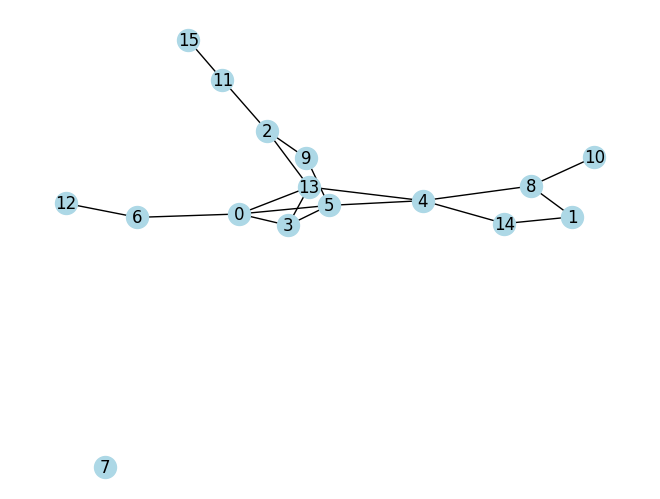

In [39]:
G = gnp_random_graph(16, 0.2)
print(G)

nx.draw(G, with_labels=True, node_color='lightblue', node_size=250)

Run the above cell a few times and note that the number of edges varies slightly among random graphs generated with the same parameters. This is because each pair of nodes has an independent chance of being an edge.

### Erdös-Rényi random graph model

Instead of specifying the link probability $p$, we can also generate a graph of $N$ nodes with exactly $M$ edges by using `random.sample()` to choose M of the possible edges generated with `itertools.combinations()`:

In [40]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))

    possible_edges = itertools.combinations(G.nodes, 2)

    edges_to_add = random.sample(list(possible_edges), M) # sample exactly M edges
    G.add_edges_from(edges_to_add)

    return G

Graph with 16 nodes and 24 edges


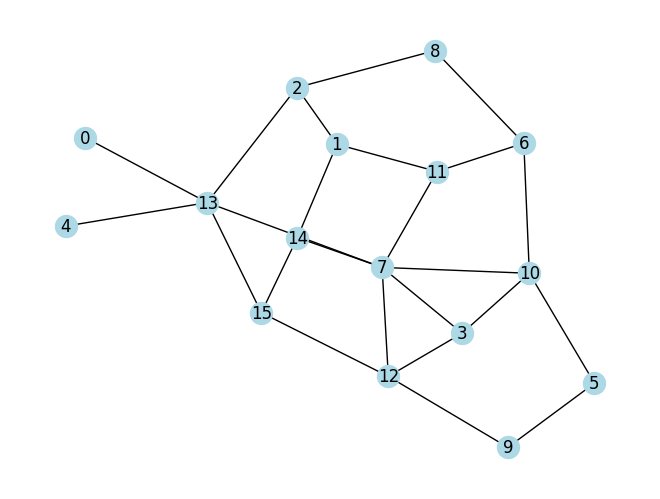

In [41]:
G = gnm_random_graph(16, 24)
print(G)

nx.draw(G, with_labels=True, node_color='lightblue', node_size=250)

### NetworkX functions

NetworkX has a function for the $G_{n,p}$ random graph specifying number of nodes $N$ and link probability $p$:  [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html).

In addition, NetworkX provides [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html), which generates a $G_{n,m}$ graph, where we specify the number of nodes $N$ and the desired number of edges $M$.

# Degree distribution of ER networks

We want to visualize the degree distribution of ER networks. We will use linear bins and plot it in linear scale. Alternatively, you can use the code from the 2nd hands-on session to plot the degree distribution in a log-log scale.

In [42]:
N = 1000
p = 0.02

G = nx.gnp_random_graph(n=N, p=p, seed=1)
print(G)

Graph with 1000 nodes and 9974 edges


In [43]:
degrees = [G.degree(n) for n in G.nodes()]
print(degrees[: 20])

[19, 27, 21, 27, 19, 17, 19, 29, 19, 24, 31, 13, 27, 19, 26, 20, 19, 21, 24, 15]


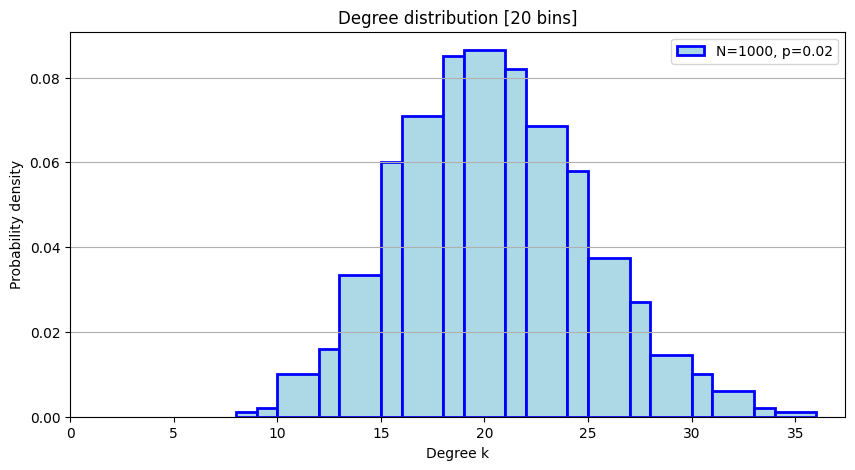

In [44]:
num_bins = 20

fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(axis='y');

bins = np.linspace(
    start=min(degrees),
    stop=max(degrees),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees, bins=bins, density=True,
    facecolor='lightblue', edgecolor='blue', linewidth=2,
    label=f'N={N}, p={p:.2f}',
);

ax.set_xlim(left=0);
ax.set_title(f'Degree distribution [{len(bins)} bins]');
ax.set_xlabel('Degree k');
ax.set_ylabel('Probability density');
ax.legend();

Let's compare the degree distributions of two ER networks side by side, each with N = 1000 nodes, and different link probabilities `0.02` and `0.05`.

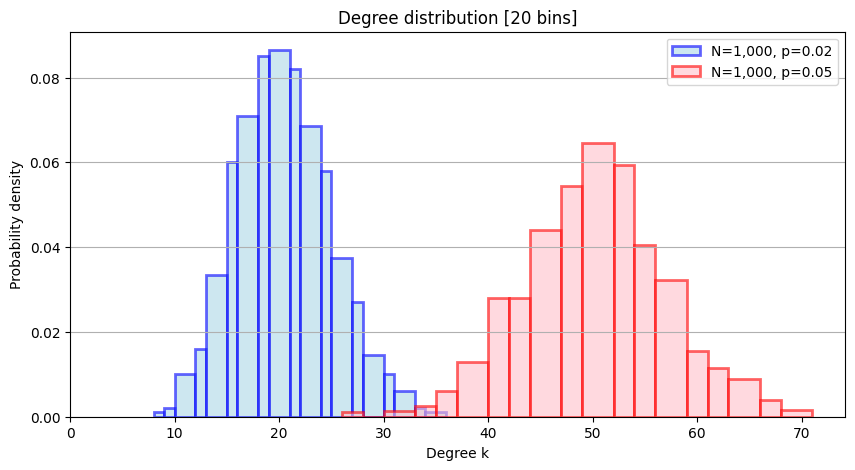

In [45]:
N = 1000
p1, p2 = 0.02, 0.05

G1 = nx.gnp_random_graph(n=N, p=p1, seed=1)
G2 = nx.gnp_random_graph(n=N, p=p2, seed=1)

degrees1 = [G1.degree(n) for n in G1.nodes()]
degrees2 = [G2.degree(n) for n in G2.nodes()]

num_bins = 20

fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(axis='y');

bins1 = np.linspace(
    start=min(degrees1),
    stop=max(degrees1),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees1, bins=bins1, density=True,
    facecolor='lightblue', edgecolor='blue', linewidth=2,
    alpha=0.6,
    label=f'N={N:,}, p={p1:.2f}',
);


bins2 = np.linspace(
    start=min(degrees2),
    stop=max(degrees2),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees2, bins=bins2, density=True,
    facecolor='pink', edgecolor='red', linewidth=2,
    alpha=0.6,
    label=f'N={N:,}, p={p2:.2f}',
);

ax.set_xlim(left=0);
ax.set_title(f'Degree distribution [{len(bins)} bins]');
ax.set_xlabel('Degree k');
ax.set_ylabel('Probability density');
ax.legend();

# Breakout 1

## Q1. Suppose we want to generate a Gilbert random network $G$ with 1000 nodes and 3000 edges. What value of edge probability $p$ in the $G(n, p)$ model will lead to this outcome? Please briefly show your work.

In [46]:
# p = (No. of edges) / (No. of possible edges)
edges = 3000
nodes = 1000

possible_edges = nodes * (nodes - 1) / 2
p = edges / possible_edges
print(p)

0.006006006006006006


## Q2. Plot the average clustering coefficient of Gilbert random networks for $p = 0.03$, and for $N = 200, 500, 1000, 2000, 5000$ as a line plot. In 1-2 sentences, comment on the general trends you observe in the plot.

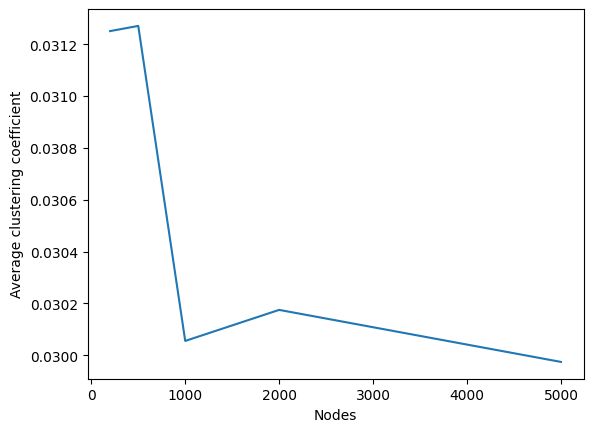

In [47]:
N1, N2, N3, N4, N5 = 200, 500, 1000, 2000, 5000
p = 0.03

ac1 = nx.average_clustering(nx.gnp_random_graph(n=N1, p=p, seed=1))
ac2 = nx.average_clustering(nx.gnp_random_graph(n=N2, p=p, seed=1))
ac3 = nx.average_clustering(nx.gnp_random_graph(n=N3, p=p, seed=1))
ac4 = nx.average_clustering(nx.gnp_random_graph(n=N4, p=p, seed=1))
ac5 = nx.average_clustering(nx.gnp_random_graph(n=N5, p=p, seed=1))

y = [ac1, ac2, ac3, ac4, ac5]
x = [N1, N2, N3, N4, N5]

plt.plot(x, y)
plt.xlabel("Nodes")  # add X-axis label
plt.ylabel("Average clustering coefficient")  # add Y-axis label
plt.show()

When the number of nodes is small, the average clustering coefficient is relatively high because there is a higher chance of forming triangles and by number of nodes increases, the average clustering coefficient decreases. This is because, with more nodes, the graph becomes sparser, and the likelihood of any three nodes forming a triangle diminishes

# 3. Configuration Model

A degree sequence is a list of $N$ numbers: $(k_1, k_2, \cdots, k_N)$, where $k_i$ is the degree of node $i$.

The configuration model takes as input a degree sequence and generates a new network with the same degree sequence.
The algorithm for creating this network is as follows:

1. Generate a list of stubs from the degree sequence, i.e., a list where each node $i$ is repeated $k_i$ many times.

2. Shuffle the stubs.

3. Pair the stubs into groups of 2, add edge between each stub pair.

In practice, we usually provide an original/input graph as an input, from which we derive the degree sequence, instead of directly passing a degree sequence.


In [48]:
[1, 2] + [3, 4]

[1, 2, 3, 4]

In [49]:
[1] * 4

[1, 1, 1, 1]

In [50]:
l1 = [1, 2, 3]
l2 = ['a', 'b', 'c']
list(zip(l1, l2))

# for a, b in zip(l1, l2):
#     print(a, b)

[(1, 'a'), (2, 'b'), (3, 'c')]

In [51]:
l = [1, 2, 3]
l.append(4)
print(l)
l.extend([5, 6, 7])
print(l)

[1, 2, 3, 4]
[1, 2, 3, 4, 5, 6, 7]


In [52]:
def configuration_model(degree_seq):
    """
    Given an degree_sequence generate a new graph GG with the same degree sequence
    """
    # generate stubs
    stubs = []

    for i, k_i in enumerate(degree_seq):
        stubs.extend([i] * k_i)

    # shuffle the stubs
    random.shuffle(stubs)

    # split in half
    half = len(stubs) // 2
    out_stubs, in_stubs = stubs[ :half], stubs[half: ]

    GG = nx.Graph()

    # add edges between stubs
    GG.add_edges_from(zip(out_stubs, in_stubs))

    return GG

Graph with 6 nodes and 7 edges


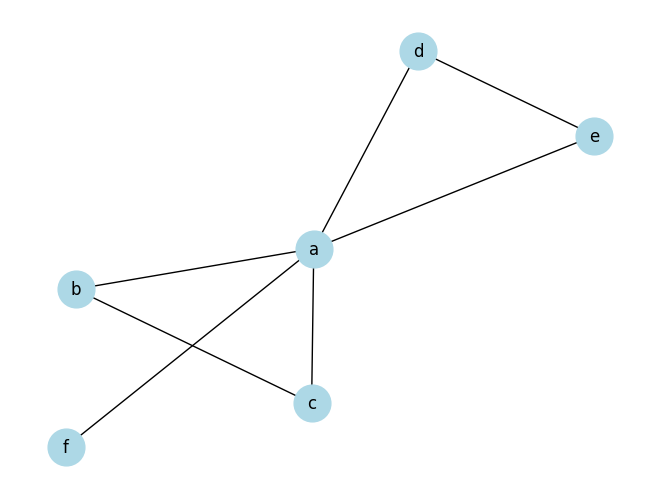

In [53]:
G = nx.Graph()
G.add_edges_from([
    ('a', 'b'), ('b', 'c'), ('a', 'c'),
    ('a', 'd'), ('a', 'e'), ('a', 'f'), ('d', 'e'),
])
print(G)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=700)

In [54]:
degree_seq = [G.degree(n) for n in G.nodes()]

Graph with 6 nodes and 7 edges


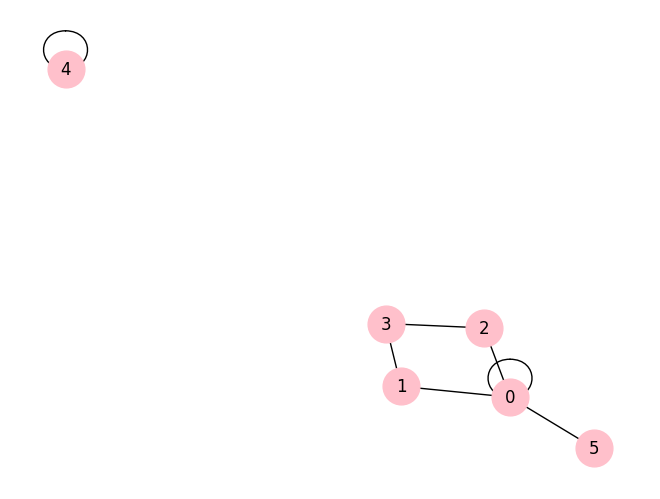

In [55]:
# generate a network with the same degree seq as G
G_config = configuration_model(degree_seq)
print(G_config)
nx.draw(
    G_config, with_labels=True, node_color='pink', node_size=700,
)
## run this cell multiple times to see different networks

Let us now compare the degree distributions of the original and the networks generated by configuration model. To show the flexibility of the model, we will examine two networks with very different degree distributions.

### NetworkX function

NetworkX has a function for the configuration model:  [nx.configuration_model()](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html).

## (a) Gilbert networks
demo of degree distributions lining up with a test network -- ER (poisson) & a real-world network

In [56]:
## example Gilbert graph with
OG_gilbert = nx.gnp_random_graph(n=1000, p=0.1, seed=2)  # matches for low p, diverges with p=0.05
print(OG_gilbert)

Graph with 1000 nodes and 49904 edges


Graph with 1000 nodes and 47489 edges


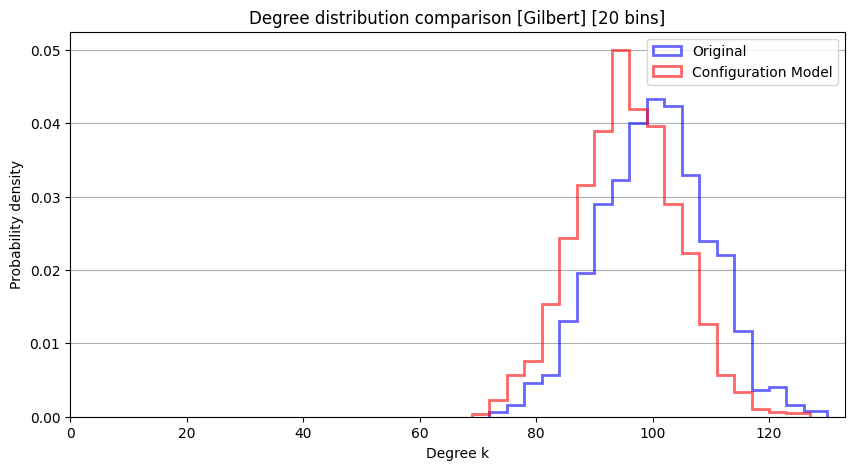

In [57]:
## fit a config model
degree_seq = [OG_gilbert.degree(n) for n in OG_gilbert.nodes()]
GG_gilbert = configuration_model(degree_seq)
print(GG_gilbert)

## plot the two degree distributions on the same plot
G1, G2 = OG_gilbert, GG_gilbert

degrees1 = [G1.degree(n) for n in G1.nodes()]
degrees2 = [G2.degree(n) for n in G2.nodes()]

num_bins = 20

fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(axis='y');

bins1 = np.linspace(
    start=min(degrees1),
    stop=max(degrees1),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees1, bins=bins1, density=True,
    facecolor='lightblue', edgecolor='blue', linewidth=2,
    alpha=0.6, histtype='step',
    label='Original',
);


bins2 = np.linspace(
    start=min(degrees2),
    stop=max(degrees2),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees2, bins=bins2, density=True,
    facecolor='pink', edgecolor='red', linewidth=2,
    alpha=0.6, histtype='step',
    label='Configuration Model',
);

ax.set_xlim(left=0);
ax.set_title(f'Degree distribution comparison [Gilbert] [{len(bins)} bins]');
ax.set_xlabel('Degree k');
ax.set_ylabel('Probability density');
ax.legend();

## (b) Real-world US flights network

In [58]:
%%capture out
%%bash
wget -O us-flights.edges.gz https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience/raw/master/datasets/openflights/openflights_usa.edges.gz
gunzip -f us-flights.edges.gz

In [59]:
OG_flights = nx.read_edgelist('us-flights.edges')
print(OG_flights)

Graph with 546 nodes and 2781 edges


Graph with 546 nodes and 2302 edges


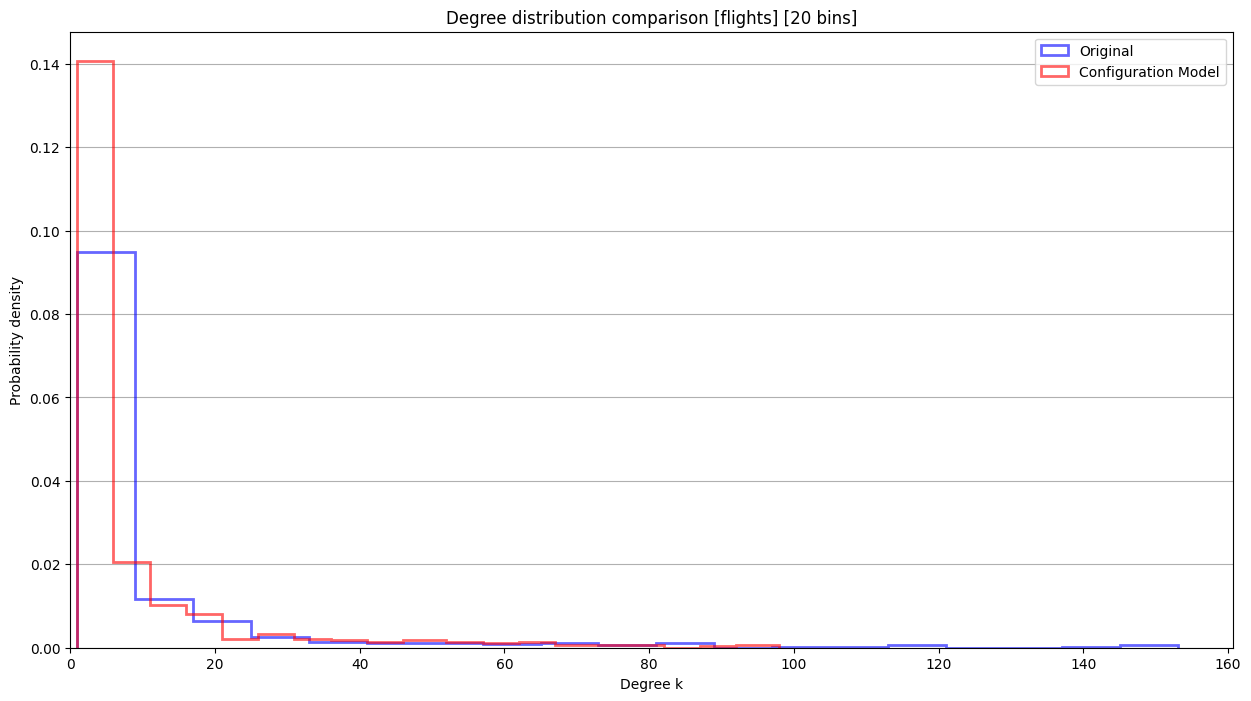

In [60]:
# fit a configuration model
degree_seq = [OG_flights.degree(n) for n in OG_flights.nodes()]
GG_flights = configuration_model(degree_seq)
print(GG_flights)

## plot the two degree distributions on the same plot
G1, G2 = OG_flights, GG_flights

degrees1 = [G1.degree(n) for n in G1.nodes()]
degrees2 = [G2.degree(n) for n in G2.nodes()]

num_bins = 20

fig, ax = plt.subplots(figsize=(15, 8))
ax.grid(axis='y');

bins1 = np.linspace(
    start=min(degrees1),
    stop=max(degrees1),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees1, bins=bins1, density=True,
    facecolor='lightblue', edgecolor='blue', linewidth=2,
    alpha=0.6, histtype='step',
    label='Original',
);


bins2 = np.linspace(
    start=min(degrees2),
    stop=max(degrees2),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees2, bins=bins2, density=True,
    facecolor='pink', edgecolor='red', linewidth=2,
    alpha=0.6, histtype='step',
    label='Configuration Model',
);

ax.set_xlim(left=0);
ax.set_title(f'Degree distribution comparison [flights] [{len(bins)} bins]');
ax.set_xlabel('Degree k');
ax.set_ylabel('Probability density');
ax.legend();

Plotting in a log-log plot.

Graph with 546 nodes and 2313 edges


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


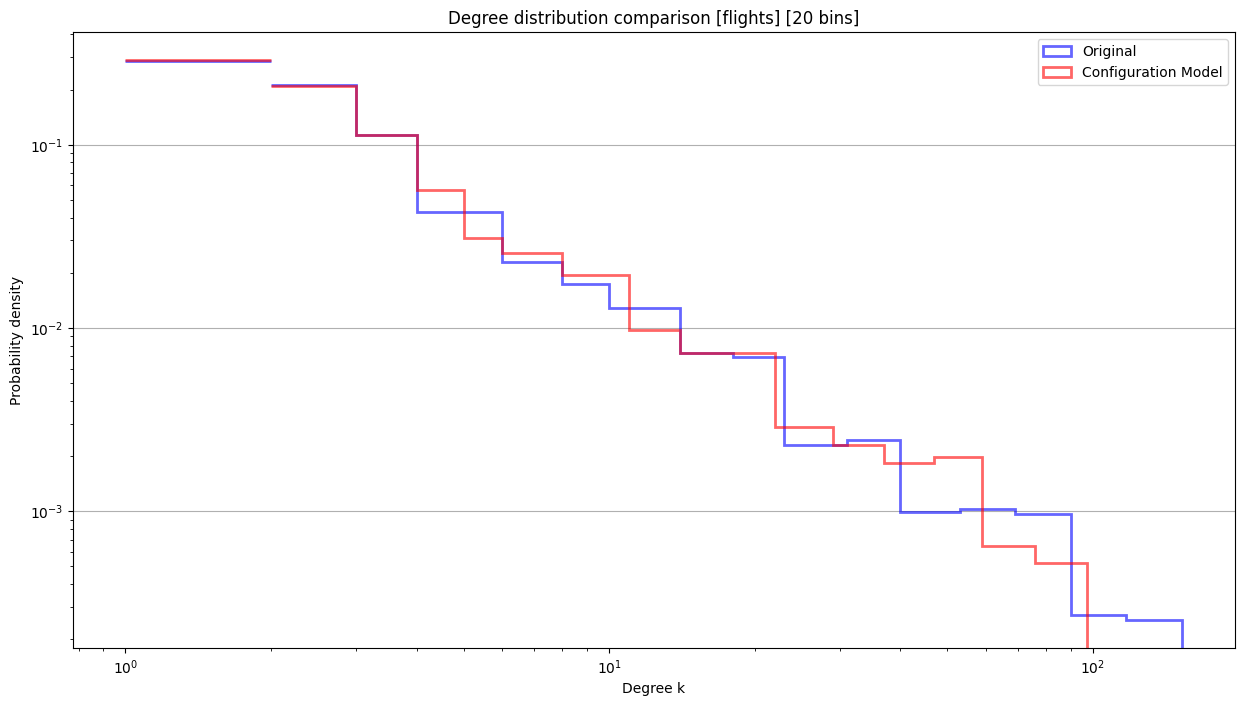

In [61]:
# fit a configuration model
degree_seq = [OG_flights.degree(n) for n in OG_flights.nodes()]
GG_flights = configuration_model(degree_seq)
print(GG_flights)

## plot the two degree distributions on the same plot
G1, G2 = OG_flights, GG_flights

degrees1 = [G1.degree(n) for n in G1.nodes()]
degrees2 = [G2.degree(n) for n in G2.nodes()]

num_bins = 20

fig, ax = plt.subplots(figsize=(15, 8))
ax.grid(axis='y');

bins1 = np.geomspace(
    start=min(degrees1),
    stop=max(degrees1),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees1, bins=bins1, density=True,
    facecolor='lightblue', edgecolor='blue', linewidth=2,
    alpha=0.6, histtype='step',
    label='Original',
);


bins2 = np.geomspace(
    start=min(degrees2),
    stop=max(degrees2),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    degrees2, bins=bins2, density=True,
    facecolor='pink', edgecolor='red', linewidth=2,
    alpha=0.6, histtype='step',
    label='Configuration Model',
);


ax.set_yscale('log');
ax.set_xscale('log');
ax.set_title(f'Degree distribution comparison [flights] [{len(bins)} bins]');
ax.set_xlabel('Degree k');
ax.set_ylabel('Probability density');
ax.legend();

## 4. Preferential Attachment Model

The Barabási-Albert preferential attachment model has two parameters: the number of nodes $N$, and the number of links added at each step $m$. Given these parameters, the algorithm is as follows:

1. Start with a clique of $m + 1$ nodes.
2. Select $m$ different nodes at random, weighted by their degree.
3. Add a new node $i$ and link it with the $m$ nodes from the previous step.
4. Repeat 2-3 until there are N nodes in the graph.

The code for this is thus straightforward, with one possible exception: for step 3, we need to generate a *degree sequence* to weight the random selection. If we have a graph `G`, we can generate such a degree sequence with a list comprehension as follows:

[4, 1, 1, 1, 1]


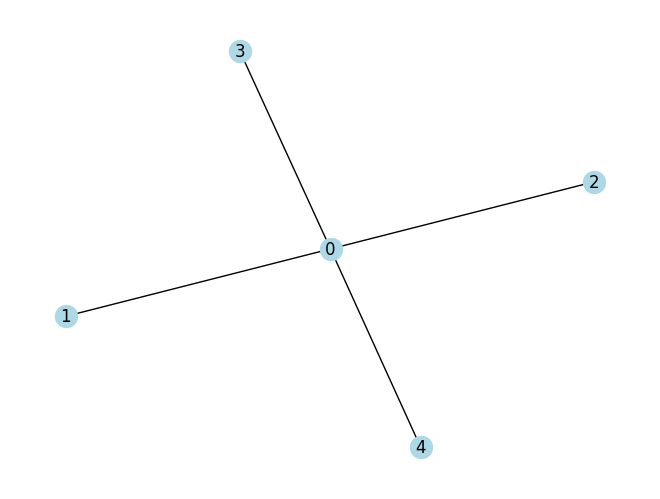

In [62]:
G = nx.star_graph(4)
degrees = [G.degree(n) for n in G.nodes]

print(degrees)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=250)

Note that the degree sequence is output in the same order as the nodes, such that the node at index $i$ in that list has the degree at index $i$ of the corresponding degree sequence. With this, we can write a function for the BA preferential attachment model:

In [63]:
def barabasi_albert_graph(N, m):
    # 1. Start with a clique of m+1 nodes
    G = nx.complete_graph(m + 1)

    for i in range(G.number_of_nodes(), N):

        # 2. Select m different nodes at random, weighted by their degree.
        new_neighbors = []
        possible_neighbors = list(G.nodes)

        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]
            j = random.choices(population=possible_neighbors, weights=degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)

        # 3. Add a new node i and link it with the m nodes from the previous step.
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

Graph with 1000 nodes and 1997 edges


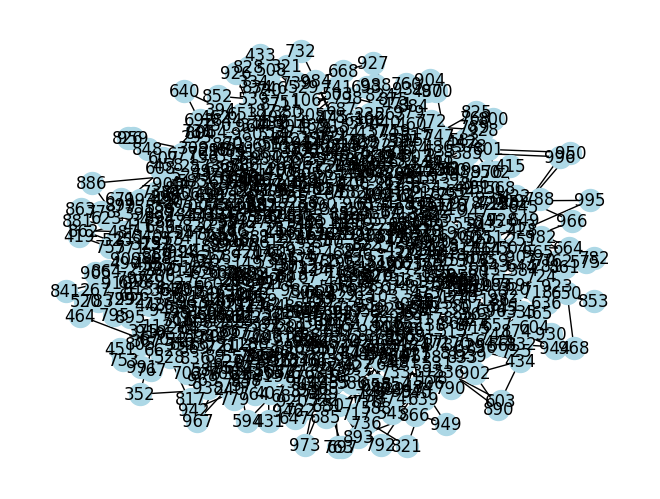

In [64]:
G = barabasi_albert_graph(1000, 2)
H = barabasi_albert_graph(1000, 900)
print(G)

nx.draw(G, with_labels=True, node_color='lightblue', node_size=250)

One might wonder why, in the previous code for `preferential_attachment_graph`, we didn't just write step 2 as

    new_neighbors = random.choices(G.nodes, degrees, k=m)
    
The issue here is that when one specifies $k > 1$ for `random.choices`, the selection is made with replacement, *i.e.* the same node can be selected from the list multiple times. The more complicated code is necessary so that we choose $m$ different nodes to join with node $i$.

### NetworkX function

As with all of these graph models, NetworkX has a function to generate a BA model: [barabasi_albert_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html).

# Breakout 2

## Programming challenge: Non-preferential attachment model

Recall, in the preferential attachment model, higher degree nodes are more likely to receive incoming links.

Here, we want to propose a variant `non-preferential-attachment` where each node, regardless of degree, has the same probability of attracting incoming links.

Please complete the following tasks.

### (1) Modify the `barabasi_albert_graph` function above to implement this model.


In [65]:
def barabasi_albert_graph_non_preferential(N, m):
    # 1. Start with a clique of m+1 nodes
    G = nx.complete_graph(m + 1)

    for i in range(G.number_of_nodes(), N):

        # 2. Select m different nodes at random
        new_neighbors = []
        possible_neighbors = list(G.nodes)

        for _ in range(m):
            j = random.choices(population=possible_neighbors)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)

        # 3. Add a new node i and link it with the m nodes from the previous step.
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

### (2) Generate two networks: `G_BA` using the Barabasi-Albert model and `G_NPA` using the `non-preferential attachmnent` model. In each model, set the number of nodes $n=1000$ and the number of edges to add in each step $m=3$.  

In [66]:
G_BA = barabasi_albert_graph(1000, 3)
G_NPA = barabasi_albert_graph_non_preferential(1000, 3)

### (3) Plot the degree distributions of `G_BA` (in red) and `G_NPA` (in blue) on the same log-log axis. Summarize your observations in 2-3 sentences.

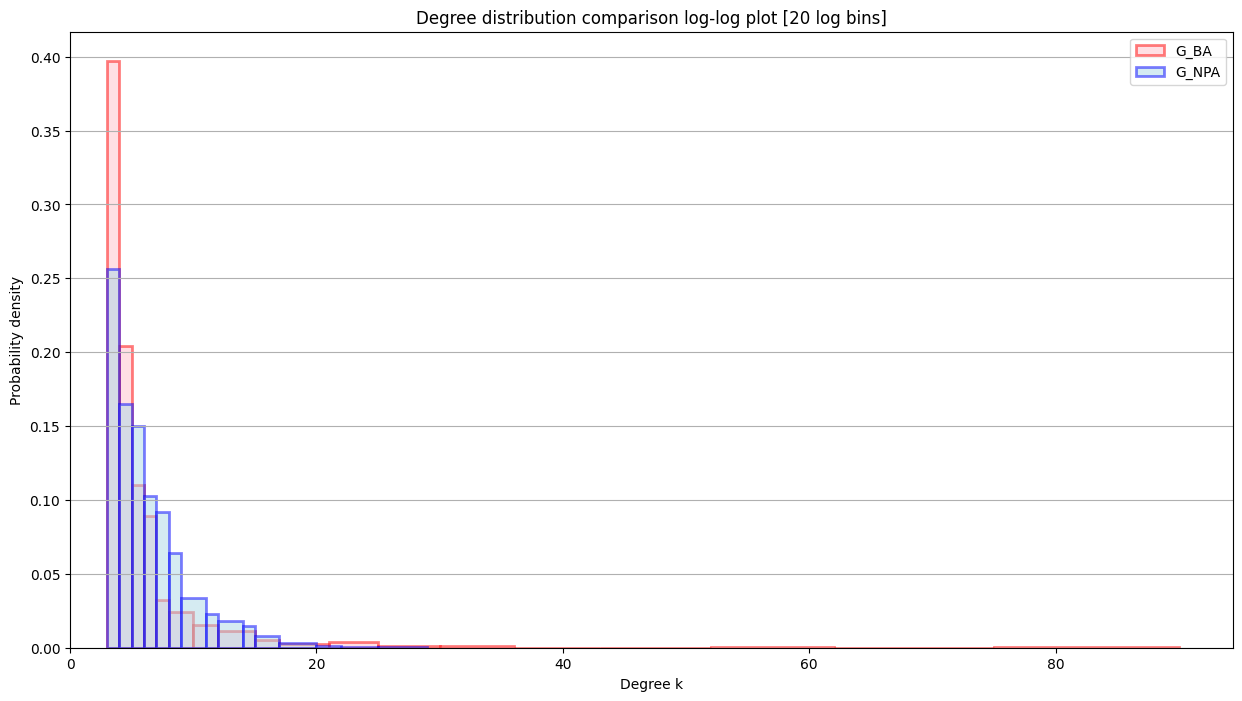

In [67]:
G_BA_degrees = [G_BA.degree(i) for i in G_BA.nodes()]
G_NPA_degrees = [G_NPA.degree(i) for i in G_NPA.nodes()]

num_bins = 20

fig, ax = plt.subplots(figsize=(15, 8))
ax.grid(axis='y');

bins1 = np.geomspace(
    start=min(G_BA_degrees),
    stop=max(G_BA_degrees),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    G_BA_degrees, bins=bins1, density=True, alpha=0.5,
    facecolor='pink', edgecolor='red', linewidth=2,
    # histtype='step',
    label='G_BA',
);

bins2 = np.geomspace(
    start=min(G_NPA_degrees),
    stop=max(G_NPA_degrees),
    num=num_bins,
).astype(int)

counts, bins, patches = ax.hist(
    G_NPA_degrees, bins=bins2, density=True, alpha=0.5,
    facecolor='lightblue', edgecolor='blue', linewidth=2,
    # histtype='step',
    label='G_NPA',
);

ax.set_xlim(left=0);
ax.set_title(f'Degree distribution comparison log-log plot [{len(bins)} log bins]');
ax.set_xlabel('Degree k');
ax.set_ylabel('Probability density');
ax.legend();

My observation is that according to the rules of non-preferential attachmnent model, all nodes have the same chance to increasing their degrees and as a result, nodes with high degrees are rare. Also, in preferential attachement mode we have nodes with big degrees and the number of nodes with very low degress are more than the other model

# Assignment submission link: https://forms.gle/NR46zxqPpoGLth8L7